In [11]:
import unittest
import numpy as np
import os
from scipy import sparse
import osqp
import copy
from lava.magma.core.run_conditions import RunSteps
from lava.proc.dense.process import Dense

from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

from lava.lib.optimization.solvers.qp.processes import (
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
)
from lava.lib.optimization.solvers.qp.ncmodels import (
    NcL2ModelPG,
    NcL2ModelPI,
)
import os
import matplotlib.pyplot as plt

In [5]:
def ruiz_equilibriation(matrix, iterations):
    """Preconditioning routine used to make the first-order QP solver converge
    faster. Returns preconditioners to be used to operate on matrices of the QP.

    Args:
        matrix (np.float): Matrix that needs to be preconditioned
        iterations (int): Number of iterations that preconditioner runs for

    Returns:
        left_preconditioner (np.float): The left preconditioning matrix
        right_preconditioner (np.float): The right preconditioning matrix

    """
    m_bar = matrix
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    for _ in range(iterations):
        D_l_inv = sparse.csc_matrix(
            np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1)))
        )
        if m_bar.shape[0] != m_bar.shape[1]:
            D_r_inv = sparse.csc_matrix(
                np.diag(1 / np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0)))
            )
        else:
            D_r_inv = D_l_inv

        m_bar = D_l_inv @ m_bar @ D_r_inv
        left_preconditioner = left_preconditioner @ D_l_inv
    return left_preconditioner, right_preconditioner

def convert_to_fp(mat, man_bits):
    """Function that returns the exponent, mantissa representation for
    floating point numbers that need to be represented on Loihi. A global exp
    is calculated for the matrices based on the max absolute value in the
    matrix. This is then used to calculate the manstissae in the matrix.

    Args:
        mat (np.float): The input floating point matrix that needs to be
        converted
        man_bits (int): number of bits that the mantissa uses for it's
        representation (Including sign)

    Returns:
        mat_fp_man (np.int): The matrix in
    """
    exp = np.ceil(np.log2(np.max(np.abs(mat)))) - man_bits + 1
    mat_fp_man = (mat // 2**exp).astype(int)
    return mat_fp_man.astype(int), exp.astype(int)

In [208]:
matrices = np.load("NeuRIPS_data/simulated_quadrotor/01_sim_quad_small_scale/mpc_172_100.npz")
# matrices = np.load("NeuRIPS_data/anymal_quadruped/01_anymal_small_scale/mpc_240_0150.npz")
Q, A, p, k = [matrices[i] for i in matrices]

# precondition matrices for first-order methods
(
    pre_mat_Q,
    _,
) = ruiz_equilibriation(Q, 10)
Q_pre = pre_mat_Q @ Q @ pre_mat_Q
p_pre = pre_mat_Q @ p

(
    pre_mat_A,
    _,
) = ruiz_equilibriation(A, 10)
A_pre = pre_mat_A @ A @ pre_mat_Q
k_pre = pre_mat_A @ k

mu = np.min(np.linalg.eigvals(Q_pre))    # lowest eigen value of cost matrix H
sigma = np.max(np.linalg.eigvals(A_pre.T@A_pre)) # Highest eigen value of G^TG
lamda = np.max(np.linalg.eigvals(Q_pre)) # Highest eigen value of cost matrix H
print("The values are mu: {}, sigma:{}, lamda:{}".format(mu, sigma, lamda))

The values are mu: 1.0, sigma:(3.4459204045421834+0j), lamda:1.0000000000000002


In [162]:
Q.shape, A.shape,k.shape, p.shape 

((172, 172), (132, 172), (132,), (172,))

In [217]:
print(sparse.csc_matrix(pre_mat_Q))

  (0, 0)	0.7071067811865476
  (1, 1)	0.7071067811865476
  (2, 2)	0.31622776601683794
  (3, 3)	0.31622776601683794
  (4, 4)	0.31622776601683794
  (5, 5)	0.31622776601683794
  (6, 6)	0.7071067811865476
  (7, 7)	0.7071067811865476
  (8, 8)	0.7071067811865476
  (9, 9)	0.4472135954999579
  (10, 10)	0.4472135954999579
  (11, 11)	0.4472135954999579
  (12, 12)	0.7071067811865476
  (13, 13)	0.7071067811865476
  (14, 14)	0.31622776601683794
  (15, 15)	0.31622776601683794
  (16, 16)	0.31622776601683794
  (17, 17)	0.31622776601683794
  (18, 18)	0.7071067811865476
  (19, 19)	0.7071067811865476
  (20, 20)	0.7071067811865476
  (21, 21)	0.4472135954999579
  (22, 22)	0.4472135954999579
  (23, 23)	0.4472135954999579
  (24, 24)	0.7071067811865476
  :	:
  (147, 147)	0.5773502691896258
  (148, 148)	0.5773502691896258
  (149, 149)	0.5773502691896258
  (150, 150)	0.5773502691896258
  (151, 151)	0.5773502691896258
  (152, 152)	0.5773502691896258
  (153, 153)	0.5773502691896258
  (154, 154)	0.5773502691896258


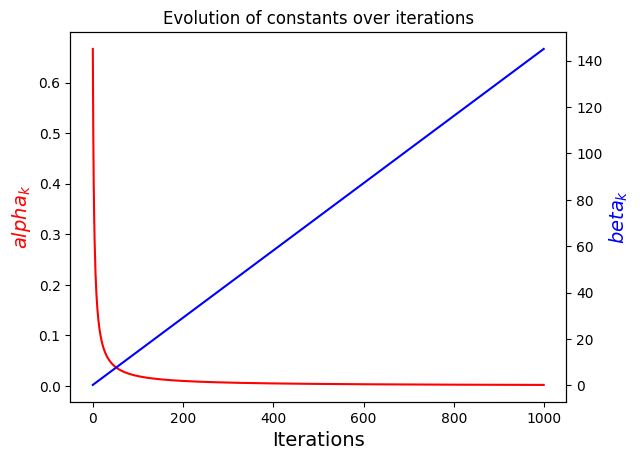

0.6666666666666665 (0.14509911469253126+0j)


In [163]:
import matplotlib.pyplot as plt

# mu, sigma, lamda =  0.11, 8.14, 1.6
# mu, sigma, lambda = 1, 447.8, 1
# mu, sigma, lambda = 1, 447.8, 1
def alpha_pipg(k):
    return 2/((k+1)*mu + 2*lamda)

def beta_pipg(k):
    return (k+1)*mu/(2*sigma)

alpha_l, beta_l  = [], []
for i in range(1000):
    alpha_l.append(alpha_pipg(i))
    beta_l.append(beta_pipg(i))
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_l, color="red")
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_l,color="blue")
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
plt.show()
print(alpha_l[0], beta_l[0])

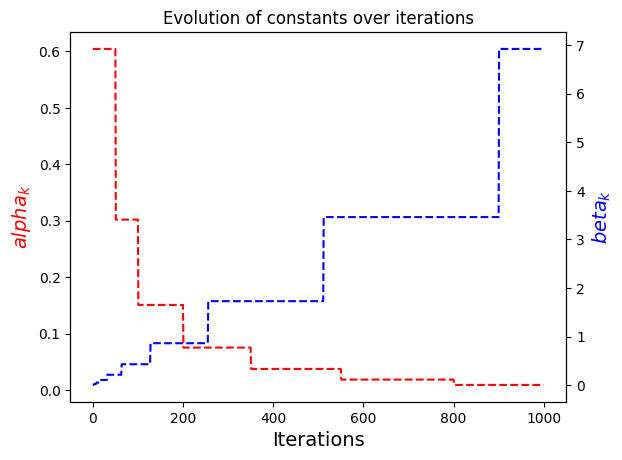

In [172]:
# Quad alpha decay
# alpha_decay_indices_list = np.array([4, 11 , 25, 46, 74, 109, 151, 200, 256, 319, 389])
# Anymal alpha decay
alpha_decay_indices_list= [50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]

beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]
alpha_lava_l , beta_lava_l = [], []
alpha_lava, beta_lava = alpha_pipg(0), beta_pipg(0)
alpha_lava_l.append(alpha_lava)
beta_lava_l.append(beta_lava)
for i in range(1000):
    if (i in alpha_decay_indices_list):
        alpha_lava/=2
    if (i in beta_growth_indices_list):
        beta_lava*=2
        
    alpha_lava_l.append(alpha_lava)
    beta_lava_l.append(beta_lava)
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_l, color="red")
ax.plot(alpha_lava_l,"--", color="red")
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_l,color="blue")
ax2.plot(beta_lava_l,"--", color="blue")
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
plt.show()

0.6042296072507553 0.006756756756756756


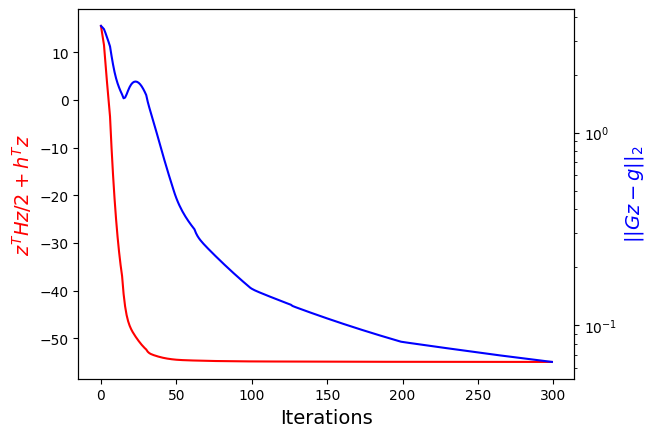

-54.91357423681963

In [179]:
# mu, sigma, lamda = 1, 40, 1
mu, sigma, lamda =  0.11, 8.14, 1.6
w = np.random.rand(A.shape[0],) 
z = np.random.rand(A.shape[1],)

sol = []
w_it = [] 
alpha_l = []
beta_l = []
constraint_sat = []
cost = []
alpha_fp = alpha_pipg(0)
beta_fp = beta_pipg(0)
print(alpha_fp, beta_fp)
for i in range(300):    
    # if (k%k_per==0):
    #     k=0
    if (i in alpha_decay_indices_list):
        alpha_fp/=2
    if (i in beta_growth_indices_list):
        beta_fp*=2   
    
    # v = w + alpha_pipg(i) * (A_pre@z - k_pre)
    # z = z - beta_pipg(i) * (Q_pre@z + p_pre + A_pre.T@v)
    # w = w + alpha_pipg(i) * (A_pre@z - k_pre)
         
    v = w + alpha_fp * (A_pre@z - k_pre)
    z = z - beta_fp * (Q_pre@z + p_pre + A_pre.T@v)
    w = w + alpha_fp * (A_pre@z - k_pre)
    
    z_post_curr = pre_mat_Q@z 
    cost.append(z_post_curr.T@Q@z_post_curr/2 + p.T@z_post_curr)
    w_it.append(w)
    sol.append(pre_mat_Q@z)
    constraint_sat.append(np.linalg.norm(A@z_post_curr - k))

convergence_z = [np.linalg.norm(t - s) for s, t in zip(sol, sol[1:])]
convergence_w = [np.linalg.norm(t - s) for s, t in zip(w_it, w_it[1:])]
fig,ax = plt.subplots()
# ax.plot(err_sol, color="red")
# ax.set_ylabel("$||z-z^*||_2$",color="red",fontsize=14)
# ax.set_yscale('log')
ax.plot(np.array(cost), color="red")
ax.set_ylabel("$z^T H z/2 + h^T z $",color="red",fontsize=14)

ax.set_xlabel("Iterations",fontsize=14)

ax2=ax.twinx()
ax2.set_yscale('log')
ax2.plot(constraint_sat,color="blue")
ax2.set_ylabel("$||Gz-g||_2$",color="blue",fontsize=14)
plt.show()
cost[-1]

In [180]:
prob = osqp.OSQP()
# Setup workspace
prob.setup(sparse.csc_matrix(Q), p, sparse.csc_matrix(A), k, k)
res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 172, constraints m = 132
          nnz(P) + nnz(A) = 884
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.3673e+01   9.47e-01   1.77e+03   1.00e-01   1.18e-03s
  25  -5.5000e+01   1.94e-04   8.40e-03   1.00e-01   1.84e-03s

status:               solved
number of itera

In [175]:
print(res.x)
print(z)

[-1.48196221e-21 -3.04401235e-23  9.99806446e-01 -9.78519276e-21
 -2.56269255e-21 -4.59664979e-22  3.39730023e-20  1.28726546e-20
  1.80823429e-05  9.25211031e-21  2.51991012e-21 -2.82055737e-22
 -1.91535370e-21  1.95958889e-22  9.99883511e-01 -8.90995695e-21
 -2.31486120e-21 -3.88847121e-22  2.20302006e-20  1.31525541e-20
  3.42002999e-05  8.17415477e-21  2.33246291e-21  1.93649206e-21
  3.48506462e-22  1.29115568e-21  9.99934079e-01 -8.15389769e-21
 -2.09654926e-21 -2.73893949e-22  3.55132945e-21 -1.34517646e-20
  2.99159267e-05  7.22255019e-21  1.62923216e-21 -6.73309195e-23
  4.35272990e-22 -7.09646468e-22  9.99965782e-01 -7.41647827e-21
 -1.97068934e-21 -3.05455425e-22 -7.37232145e-21  9.45501809e-21
  2.02374772e-05  7.22482413e-21  1.44808325e-21 -2.46925073e-22
 -5.83105183e-22 -1.08307762e-22  9.99984740e-01 -6.70646066e-21
 -1.79054677e-21 -2.86728258e-22 -1.12345341e-21  1.96714303e-21
  1.12232549e-05  6.73704242e-21  1.56742103e-21 -4.01938176e-22
 -4.03669552e-22 -2.21905

### Single problem from dataset

In [28]:
def solve_qp(path, file_list, iter=100, type="anymal"):
    for file in sorted(file_list):
        print(file)
        a = np.load(path+file)
        Q, A, p, k = [a[i] for i in a] 
        
    
        if type=="anymal":
            # Quasi-static Variables       
            # 0.0625
            alpha_man = 160
            alpha_exp = -8

            #0.00683
            beta_man = 7
            beta_exp = -10
            
            alpha_decay_indices_list = (
                np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]) * 2
            )
            beta_growth_indices_list = (
                np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2045, 4095])
                * 2
                + 1
            )
            k = k.reshape(k.shape[0], )
            p = p.reshape(p.shape[0], )

        if type=="sim_quad":
            # Quasi-static Variables
            # 0.625
            alpha_man = 160
            alpha_exp = -8
            
            # 0.0125
            beta_man = 7
            beta_exp = -9

            alpha_decay_indices_list = (
                np.array([4, 11 , 25, 46, 74, 109, 151, 200, 256, 319, 389]) * 2
            )
            # alpha_decay_indices_list = (
            #     np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300]) * 2
            # )
            beta_growth_indices_list = (
                np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2045, 4095])
                * 2
                + 1
            )
        
        print(Q.shape, A.shape, p.shape, k.shape)
        # precondition matrices for first-order methods
        (
            pre_mat_Q,
            _,
        ) = ruiz_equilibriation(Q, 5)
        Q_pre = pre_mat_Q @ Q @ pre_mat_Q
        p_pre = pre_mat_Q @ p

        (
            pre_mat_A,
            _,
        ) = ruiz_equilibriation(A, 5)
        A_pre = pre_mat_A @ A @ pre_mat_Q
        k_pre = pre_mat_A @ k

        init_state_x = np.zeros(p.shape).astype(np.int32)
        init_state_w = np.zeros(k.shape).astype(np.int32)

        # ANYmal mu, sigma, lamda
        if type=="anymal":
            k_pre_fp_man, k_pre_fp_exp = k_pre.astype(int), 0  
        
        if type=="sim_quad":
            k_pre_fp_man, k_pre_fp_exp = convert_to_fp(k_pre, 16)
        
        # Quadrotor
        # mu, sigma, lamda = 1, 1, 1

        # mu, sigma, lamda = 1, 447.5, 1

        Q_pre_fp_man, Q_pre_fp_exp = convert_to_fp(Q_pre, 8)
        A_pre_fp_man, A_pre_fp_exp = convert_to_fp(A_pre, 8)
        p_pre_fp_man, p_pre_fp_exp = convert_to_fp(p_pre, 16)

        state_var_x_py = init_state_x
        decay_counter = 0

        state_var_w_py = init_state_w + np.right_shift(
            beta_man * (-np.right_shift(k_pre_fp_man, -k_pre_fp_exp)),
            -beta_exp,
        )
        gamma_py = init_state_w
        growth_counter = 0

        iterations = iter * 2
        correction_exp = -min(A_pre_fp_exp, Q_pre_fp_exp)
        print("Correction_exp is {} A_pre_fp_exp is {} and Q_pre_fp_exp is {}".format(correction_exp, A_pre_fp_exp, Q_pre_fp_exp))
        Q_exp_new, A_exp_new = (
            correction_exp + Q_pre_fp_exp,
            correction_exp + A_pre_fp_exp,
        )
        A_pre_fp_man = (A_pre_fp_man // 2) * 2
        Q_pre_fp_man = (Q_pre_fp_man // 2) * 2
        cost = []
        constraint_sat = []
        for i in range(1, iterations):
            a_in_pg_1 = (A_pre_fp_man).T @ gamma_py

            a_in_pg_1 = np.left_shift(a_in_pg_1, A_exp_new)

            a_in_pg_2 = Q_pre_fp_man @ state_var_x_py
            a_in_pg_2 = np.left_shift(a_in_pg_2, Q_exp_new)

            a_in_pg = a_in_pg_1 + a_in_pg_2
            a_in_pg = np.right_shift(a_in_pg, correction_exp)

            decay_counter += 1
            if decay_counter % 2 == 0:
                if decay_counter in alpha_decay_indices_list:
                    alpha_man //= 2
                tot_bias_gd = alpha_man * (
                    a_in_pg + np.right_shift(p_pre_fp_man, -p_pre_fp_exp)
                )

                x_inter = np.right_shift(tot_bias_gd, -alpha_exp)

                state_var_x_py -= x_inter
                # print("The constraint violation is {}".format(np.linalg.norm(A_pre @ state_var_x_py - k_pre)))
                # cost.append(state_var_x_py.T@Q_pre@state_var_x_py/2 + p_pre.T@state_var_x_py)
                curr_post_sol = pre_mat_Q@state_var_x_py
                cost.append(curr_post_sol.T@Q@curr_post_sol/2 + p.T@curr_post_sol)
                constraint_sat.append(np.linalg.norm(A@curr_post_sol - k))
                # sol_list.append(state_var_x_py)
            a_in_pi = A_pre_fp_man @ state_var_x_py
            a_in_pi = np.right_shift(a_in_pi, -A_pre_fp_exp)

            growth_counter += 1
            if growth_counter % 2 == 1:
                if growth_counter in beta_growth_indices_list:
                    beta_man *= 2
                tot_bias_pi = beta_man * (
                    a_in_pi - np.right_shift(k_pre_fp_man, -k_pre_fp_exp)
                )
            
                omega = np.right_shift(tot_bias_pi, -beta_exp)
                state_var_w_py += omega
                gamma_py = state_var_w_py + omega

        fig,ax = plt.subplots()
        # ax.plot(err_sol, color="red")
        # ax.set_ylabel("$||z-z^*||_2$",color="red",fontsize=14)
        # ax.set_yscale('log')
    
        ax.plot(np.array(cost[:]), color="red")
        ax.set_ylabel("$z^T H z/2 + h^T z $",color="red",fontsize=14)

        ax.set_xlabel("Iterations",fontsize=14)

        ax2=ax.twinx()
        ax2.set_yscale('log')
        ax2.set_ylim(bottom=0.1, top=10**5)
        ax2.plot(constraint_sat,color="blue")
        ax2.set_ylabel("$||Gz-g||_2$",color="blue",fontsize=14)
        plt.show()

        prob = osqp.OSQP()
        # Setup workspace
        prob.setup(sparse.csc_matrix(Q), p, sparse.csc_matrix(A), k, k)
        res = prob.solve()
        # print(curr_post_sol)
        # print(res.x)
        # print(sparse.csc_matrix(Q))
        # plt.hist(Q[np.abs(Q>0)])
        # plt.show()
        # plt.hist(Q_pre_fp_man[np.abs(Q_pre_fp_man)>0])
        # plt.show()

        print("The constraint violation is {}".format(np.linalg.norm(constraint_sat[-1])))
        print("Optimal cost from Loihi solver is {} and osqp is {}".format(cost[-1], res.info.obj_val))
        print("Error to optimal cost: {} percent".format((cost[-1] - res.info.obj_val)/res.info.obj_val*100))
        print("Constraint Violation improvement: {} percent".format((np.linalg.norm(constraint_sat[-2])-np.linalg.norm(constraint_sat[-1]))/np.linalg.norm(constraint_sat[-2])*100))

----------------QUAD-------------------
(172, 172) (132, 172) (172,) (132,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


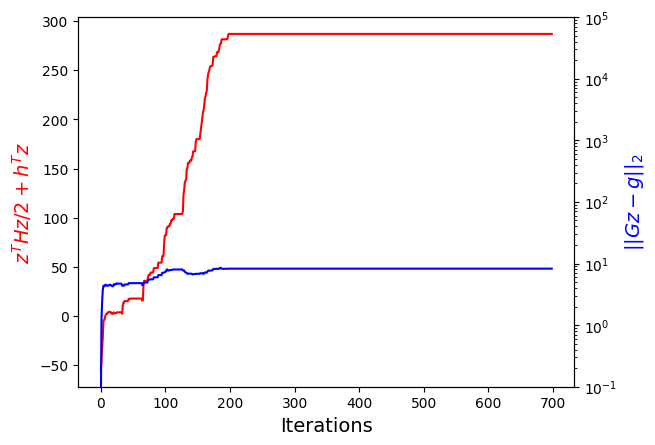

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 172, constraints m = 132
          nnz(P) + nnz(A) = 884
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.3673e+01   9.47e-01   1.77e+03   1.00e-01   2.04e-04s
  25  -5.5000e+01   1.94e-04   8.40e-03   1.00e-01   3.87e-04s

status:               solved
number of itera

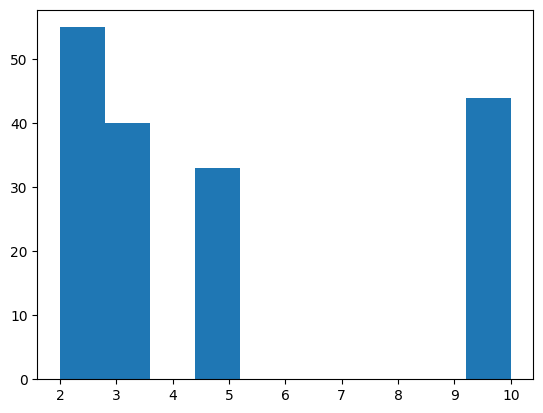

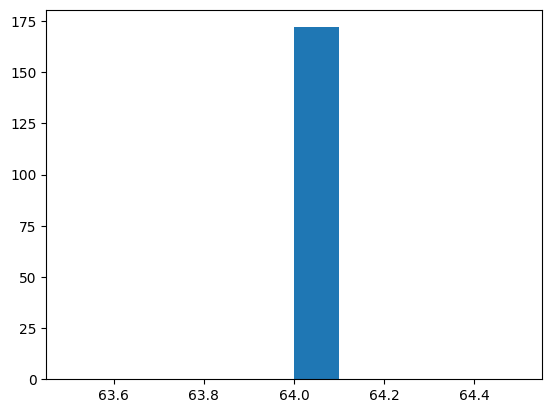

The constraint violation is 8.261559697284877
Optimal cost from Loihi solver is 286.9256180500657 and osqp is -54.99999971159346


In [215]:
print("----------------QUAD-------------------")
solve_qp(dir_name="NeuRIPS_data/simulated_quadrotor/01_sim_quad_small_scale/mpc_172_100.npz", 
         type="sim_quad")


---------------ANYMAL-----------------
mpc_2400_0150.npz
(2424, 2424) (1224, 2424) (2424,) (1224,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


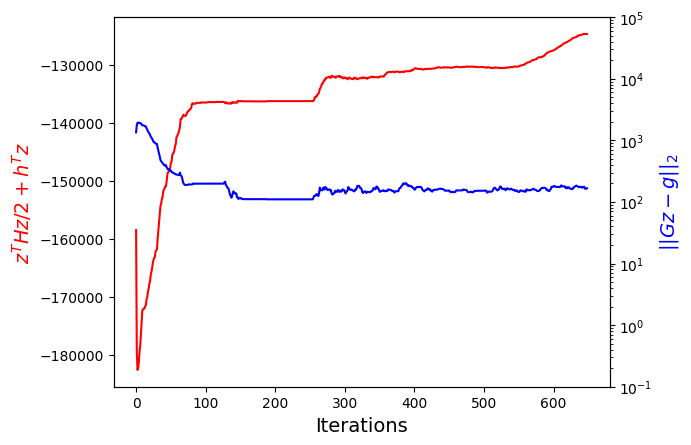

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 10383
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -8.8978e+04   3.33e-02   1.81e+00   1.00e-01   1.66e-03s
  25  -1.3888e+05   2.90e-06   8.50e-06   1.00e-01   2.49e-03s

status:               solved
number of i

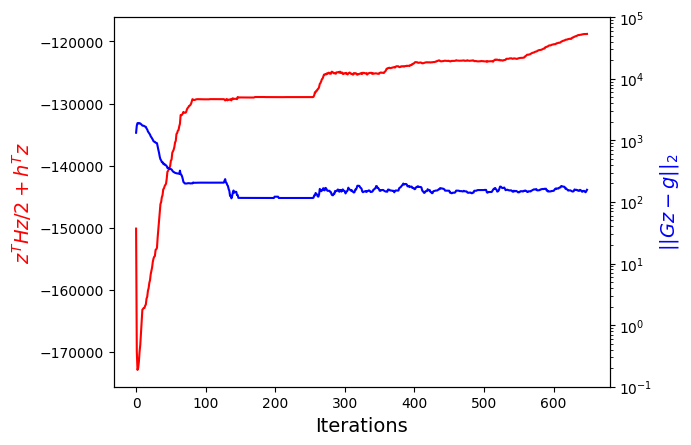

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 10461
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -8.4448e+04   3.55e-02   1.81e+00   1.00e-01   1.79e-03s
  25  -1.3180e+05   2.32e-06   8.50e-06   1.00e-01   2.62e-03s

status:               solved
number of i

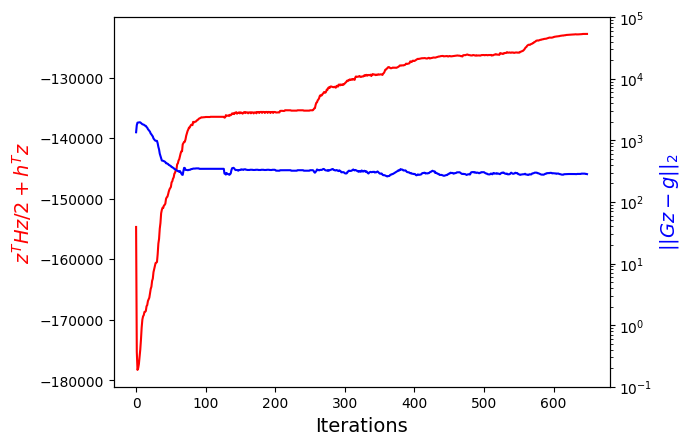

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 10376
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -8.6793e+04   2.96e-02   1.81e+00   1.00e-01   1.72e-03s
  25  -1.3547e+05   2.90e-06   8.50e-06   1.00e-01   2.54e-03s

status:               solved
number of i

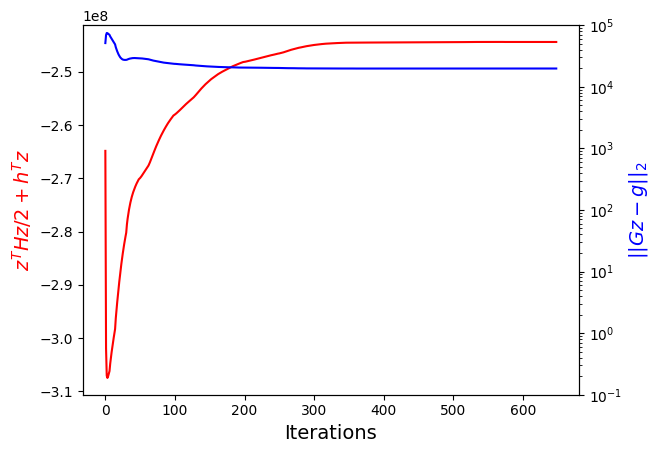

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 11935
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7388e+08   5.23e-03   3.86e+02   1.00e-01   2.99e-03s
  25  -2.4080e+08   5.86e-07   3.56e-02   1.00e-01   4.26e-03s

status:               solved
number of i

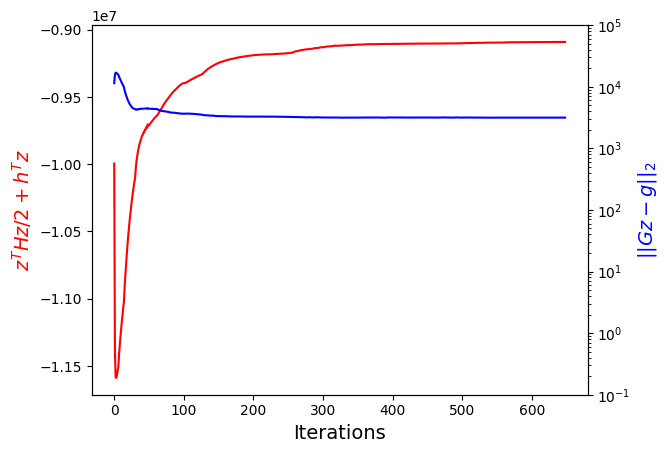

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 12557
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.7878e+06   3.24e-02   3.06e+01   1.00e-01   2.93e-03s
  25  -8.9639e+06   3.79e-06   1.70e-04   1.00e-01   4.29e-03s

status:               solved
number of i

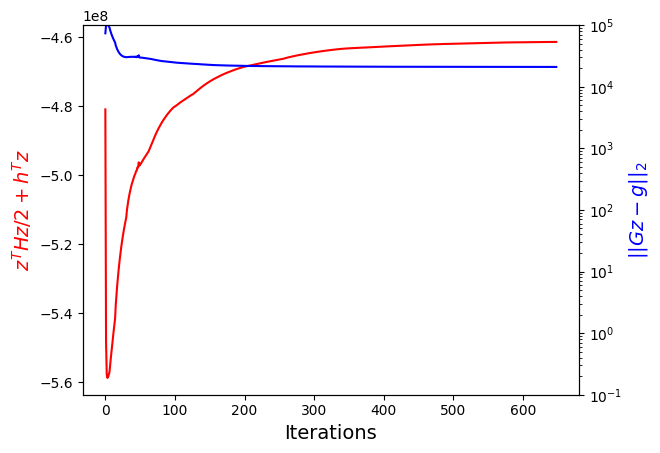

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 13454
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.1255e+08   2.00e-02   1.90e+02   1.00e-01   2.48e-03s
  25  -4.5329e+08   1.94e-06   8.67e-03   1.00e-01   3.73e-03s

status:               solved
number of i

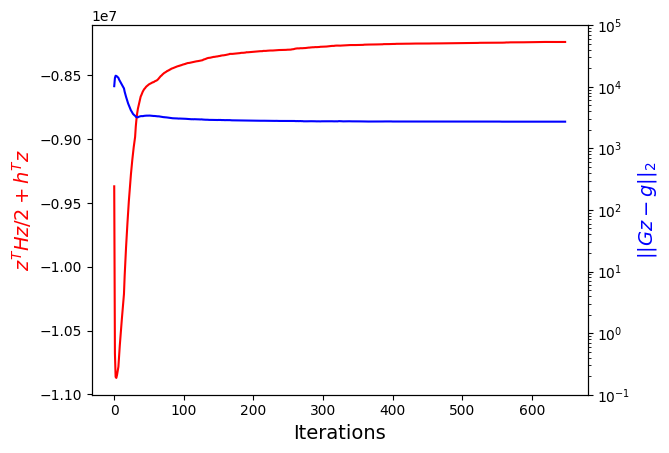

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 12148
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.2966e+06   4.25e-02   3.06e+01   1.00e-01   2.39e-03s
  25  -8.2076e+06   4.99e-06   1.75e-04   1.00e-01   3.59e-03s

status:               solved
number of i

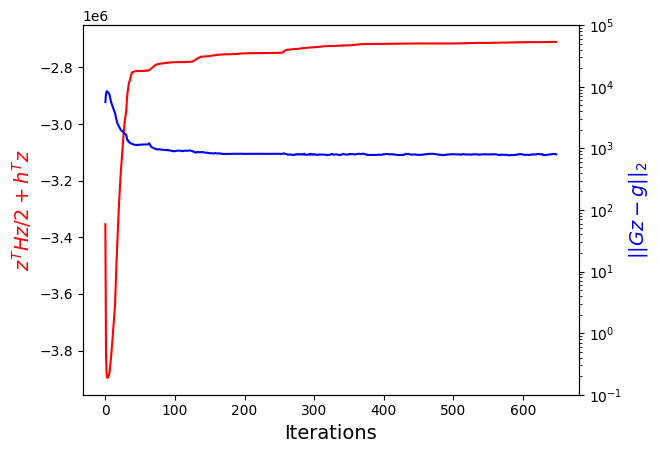

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 12695
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7480e+06   1.33e-01   7.71e+00   1.00e-01   2.30e-03s
  25  -2.7263e+06   1.52e-05   4.17e-05   1.00e-01   3.55e-03s

status:               solved
number of i

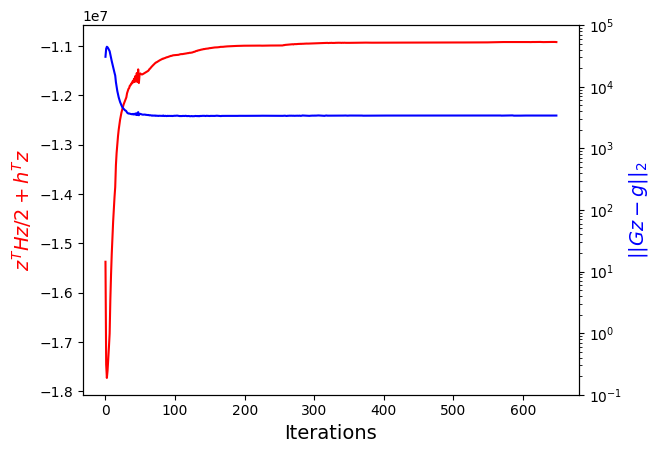

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 13364
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.5810e+06   5.65e-02   4.04e+01   1.00e-01   2.46e-03s
  25  -1.0132e+07   6.63e-06   3.55e-04   1.00e-01   3.66e-03s

status:               solved
number of i

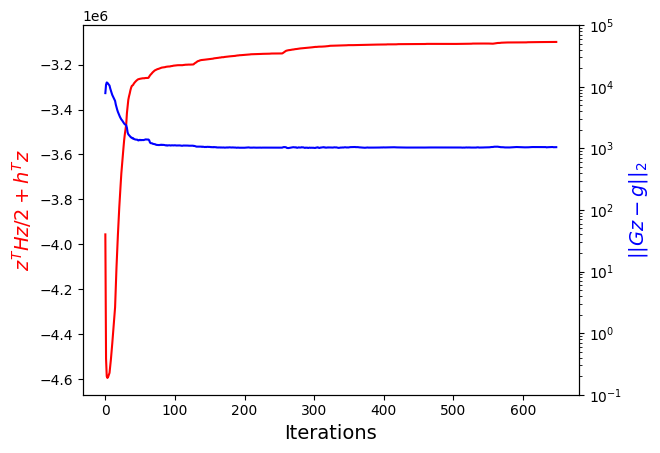

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2424, constraints m = 1224
          nnz(P) + nnz(A) = 11761
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.0135e+06   1.39e-01   8.87e+00   1.00e-01   2.39e-03s
  25  -3.1396e+06   1.62e-05   4.30e-05   1.00e-01   3.59e-03s

status:               solved
number of i

In [64]:
ser_no = "02"
scale_dict = {'01':"small", '02':"medium", '03':"medium_large",'04':"full", '05':"extra_full" }
path = "NeuRIPS_data/anymal_quadruped/"+ser_no+"_anymal_"+scale_dict[ser_no]+"_scale/"
file_list=os.listdir(path)
print("---------------ANYMAL-----------------")
# solve_qp(path=path,file_list=[sorted(file_list)[3]], iter=650, type="anymal")
solve_qp(path=path,file_list=file_list, iter=650, type="anymal")

---------------ANYMAL-----------------
mpc_3600_0150.npz
(3624, 3624) (1824, 3624) (3624,) (1824,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


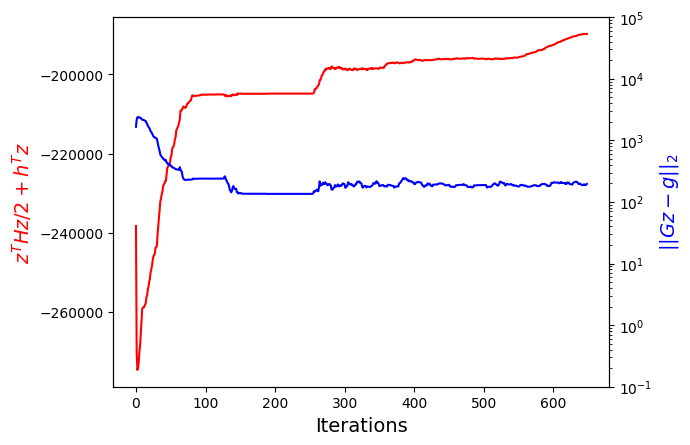

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 15536
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.3390e+05   3.33e-02   1.81e+00   1.00e-01   2.41e-03s
  25  -2.0900e+05   2.90e-06   8.50e-06   1.00e-01   3.64e-03s

status:               solved
number of i

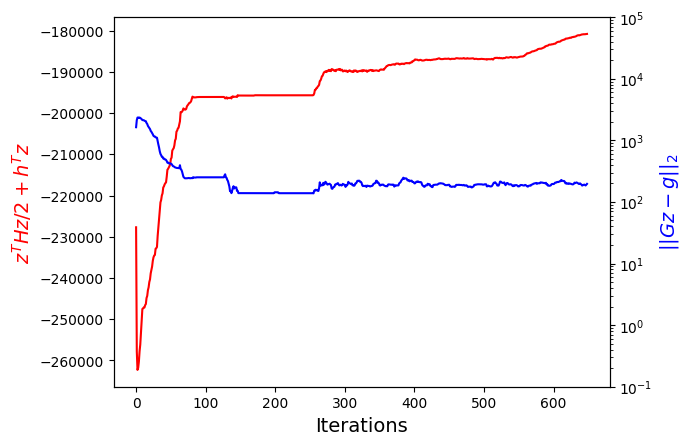

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 15646
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2812e+05   3.55e-02   1.81e+00   1.00e-01   2.43e-03s
  25  -1.9998e+05   2.32e-06   8.50e-06   1.00e-01   3.66e-03s

status:               solved
number of i

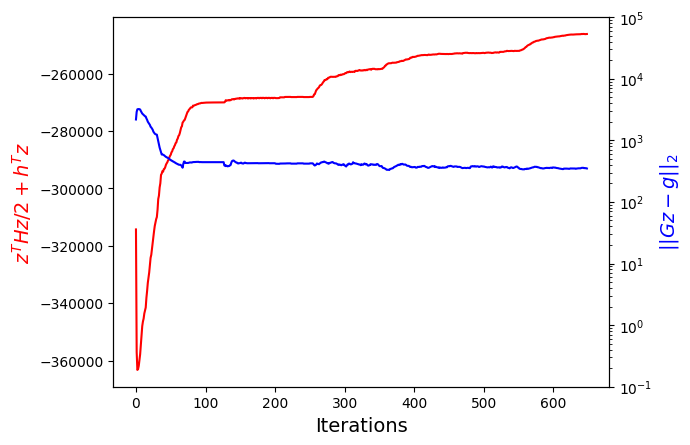

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 15735
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7220e+05   1.33e-02   4.40e+00   1.00e-01   2.70e-03s
  25  -2.6859e+05   1.57e-06   2.05e-05   1.00e-01   4.11e-03s

status:               solved
number of i

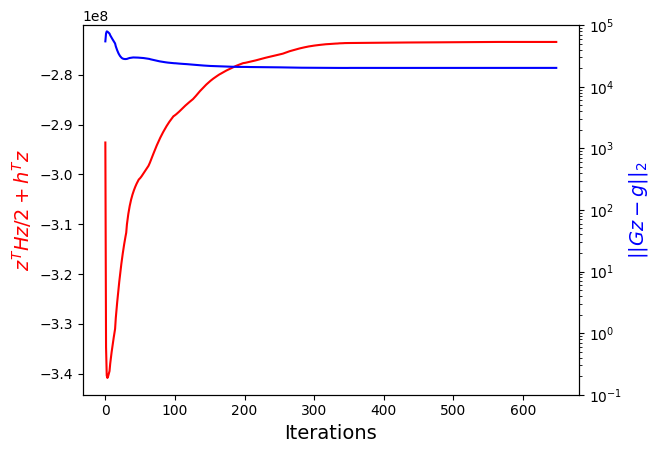

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 18560
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.9545e+08   5.23e-03   3.86e+02   1.00e-01   3.81e-03s
  25  -2.6960e+08   5.86e-07   3.56e-02   1.00e-01   5.65e-03s

status:               solved
number of i

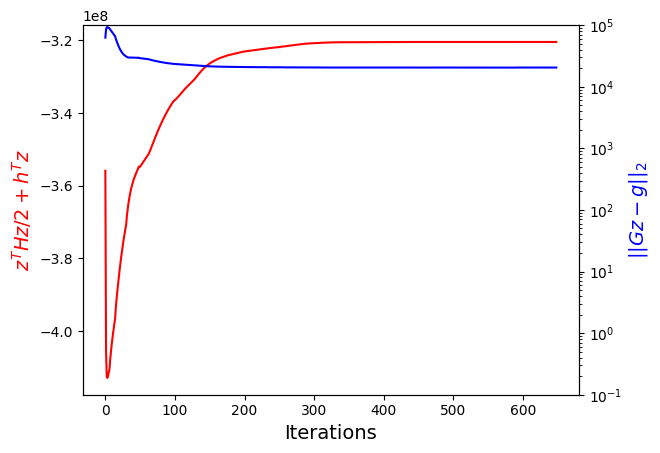

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 18846
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.2978e+08   1.34e-02   4.55e+02   1.00e-01   3.93e-03s
  25  -3.1900e+08   1.25e-06   3.36e-02   1.00e-01   5.79e-03s

status:               solved
number of i

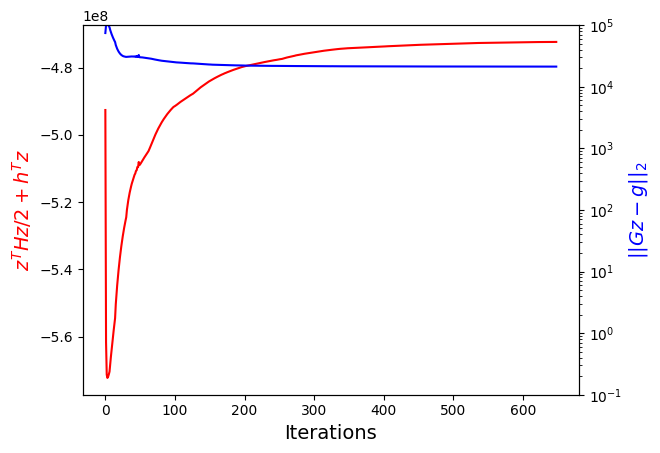

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 19968
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2005e+08   2.00e-02   1.90e+02   1.00e-01   3.73e-03s
  25  -4.6402e+08   1.94e-06   8.67e-03   1.00e-01   5.62e-03s

status:               solved
number of i

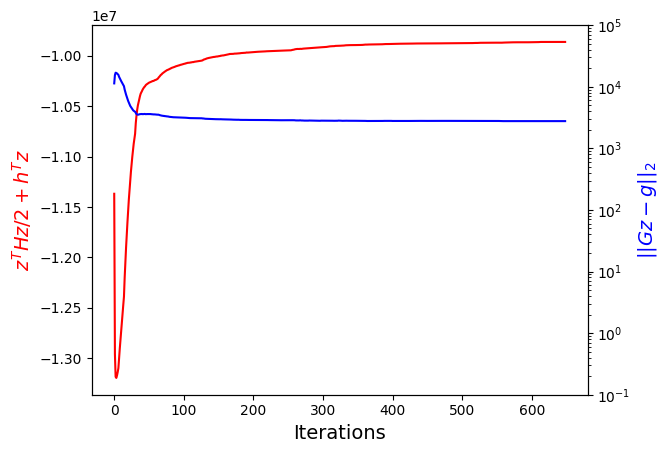

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 17877
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.3387e+06   4.25e-02   3.06e+01   1.00e-01   3.53e-03s
  25  -9.8255e+06   4.99e-06   1.75e-04   1.00e-01   5.33e-03s

status:               solved
number of i

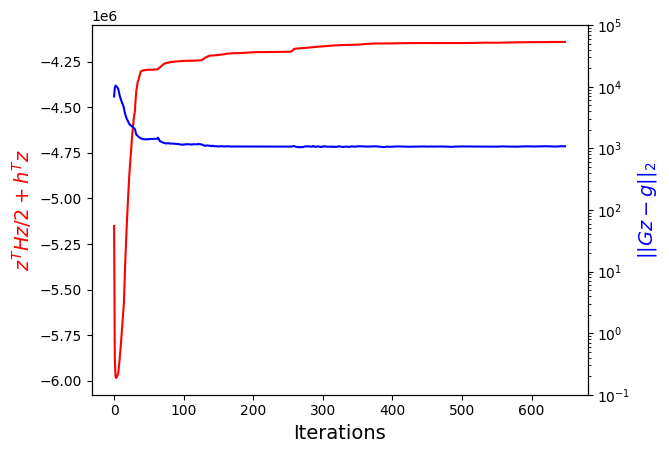

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 19033
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.6755e+06   1.27e-01   8.12e+00   1.00e-01   3.45e-03s
  25  -4.1728e+06   1.45e-05   4.39e-05   1.00e-01   5.37e-03s

status:               solved
number of i

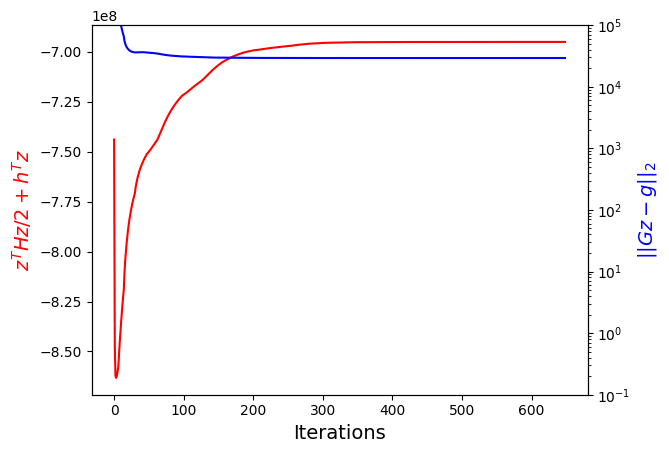

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 20065
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -4.8995e+08   1.09e-02   3.47e+02   1.00e-01   3.82e-03s
  25  -6.8276e+08   1.12e-06   2.02e-02   1.00e-01   5.71e-03s

status:               solved
number of i

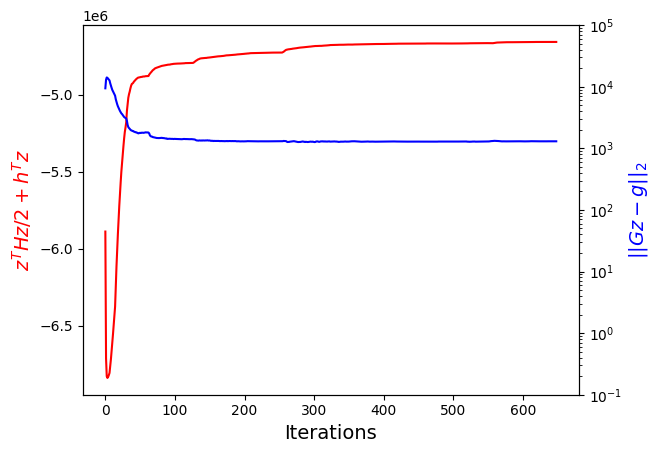

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 3624, constraints m = 1824
          nnz(P) + nnz(A) = 17546
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.0140e+06   1.39e-01   8.87e+00   1.00e-01   3.48e-03s
  25  -4.6997e+06   1.62e-05   4.30e-05   1.00e-01   5.33e-03s

status:               solved
number of i

In [65]:
ser_no = "03"
scale_dict = {'01':"small", '02':"medium", '03':"medium_large",'04':"full", '05':"extra_full" }
path = "NeuRIPS_data/anymal_quadruped/"+ser_no+"_anymal_"+scale_dict[ser_no]+"_scale/"
file_list=os.listdir(path)
print("---------------ANYMAL-----------------")
# solve_qp(path=path,file_list=[sorted(file_list)[3]], iter=650, type="anymal")
solve_qp(path=path,file_list=file_list, iter=650, type="anymal")

---------------ANYMAL-----------------
mpc_4800_0150.npz
(4824, 4824) (2424, 4824) (4824,) (2424,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


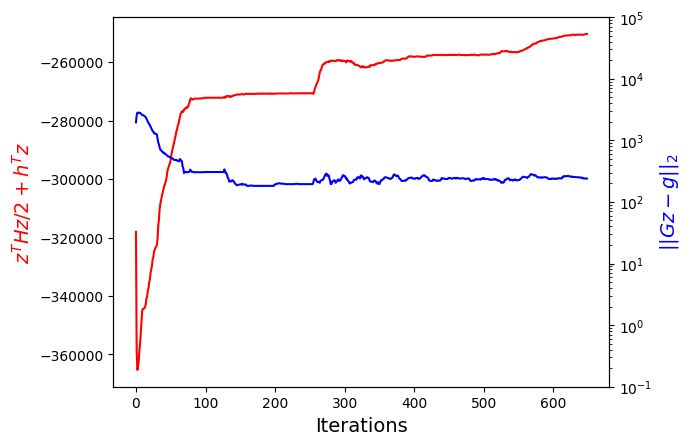

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 24660
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7915e+05   3.33e-02   1.81e+00   1.00e-01   4.13e-03s
  25  -2.7966e+05   2.90e-06   8.50e-06   1.00e-01   6.42e-03s

status:               solved
number of i

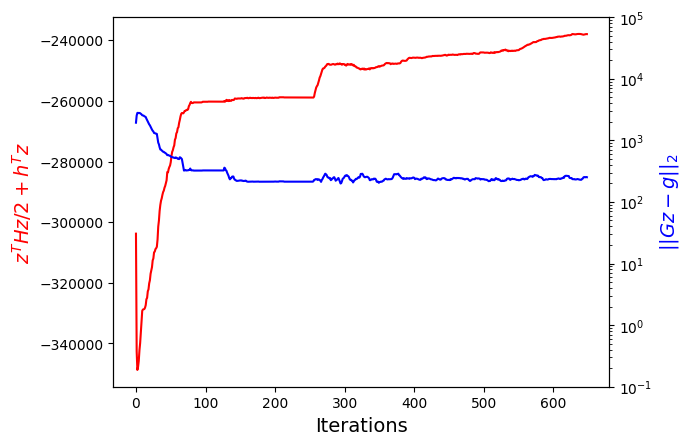

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 24785
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.7129e+05   3.55e-02   1.81e+00   1.00e-01   4.13e-03s
  25  -2.6738e+05   2.32e-06   8.50e-06   1.00e-01   6.40e-03s

status:               solved
number of i

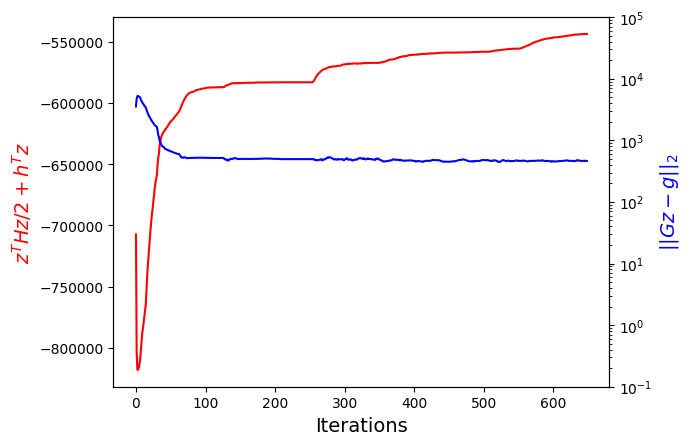

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 25592
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.7663e+05   1.38e-02   5.13e+00   1.00e-01   4.76e-03s
  25  -5.8749e+05   1.62e-06   2.39e-05   1.00e-01   7.35e-03s

status:               solved
number of i

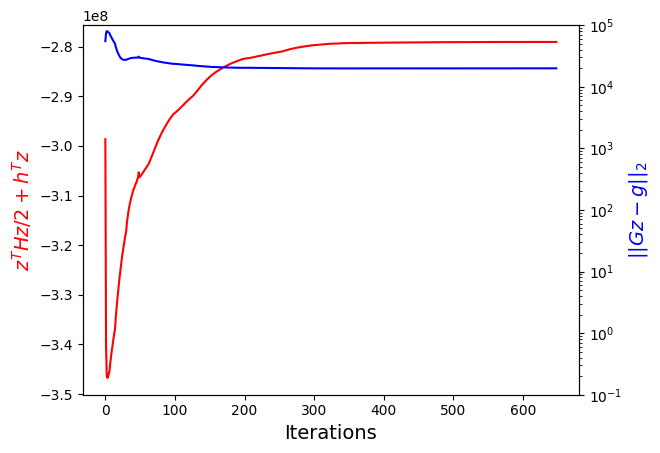

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27256
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.9921e+08   5.23e-03   3.86e+02   1.00e-01   4.83e-03s
  25  -2.7440e+08   5.86e-07   3.56e-02   1.00e-01   7.50e-03s

status:               solved
number of i

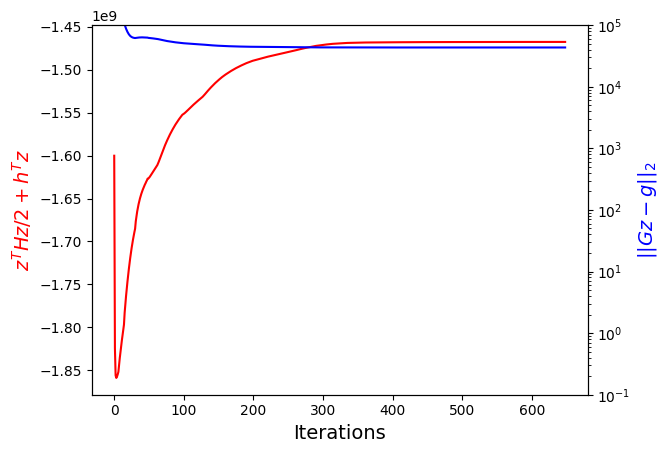

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27488
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0693e+09   7.06e-03   8.54e+02   1.00e-01   4.70e-03s
  25  -1.4482e+09   7.62e-07   7.10e-02   1.00e-01   7.19e-03s

status:               solved
number of i

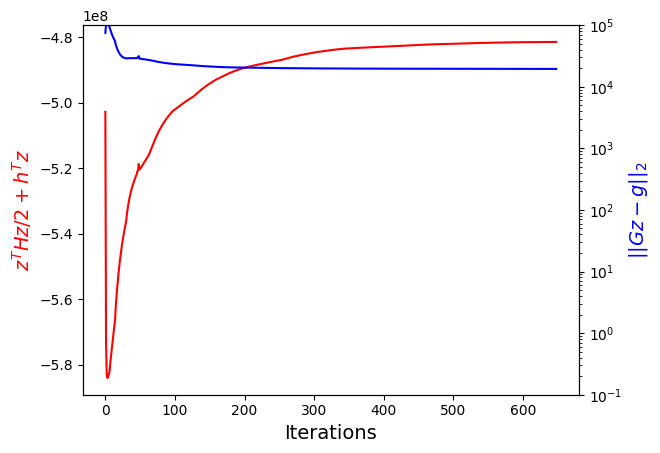

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27796
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2660e+08   2.00e-02   1.90e+02   1.00e-01   4.40e-03s
  25  -4.7341e+08   1.94e-06   8.68e-03   1.00e-01   6.89e-03s

status:               solved
number of i

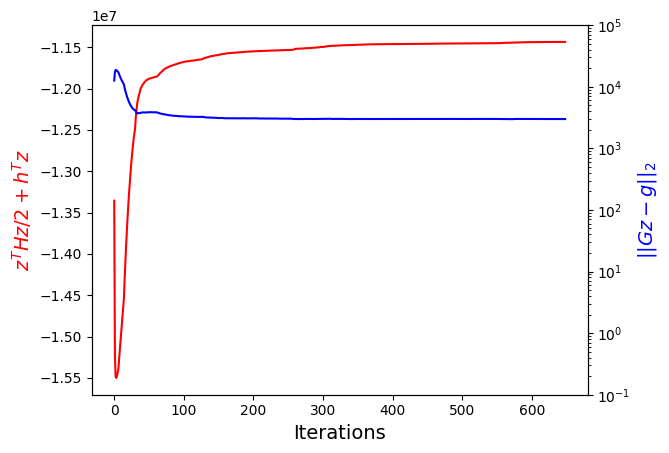

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27051
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -7.3693e+06   4.25e-02   3.06e+01   1.00e-01   4.48e-03s
  25  -1.1426e+07   4.99e-06   1.75e-04   1.00e-01   7.00e-03s

status:               solved
number of i

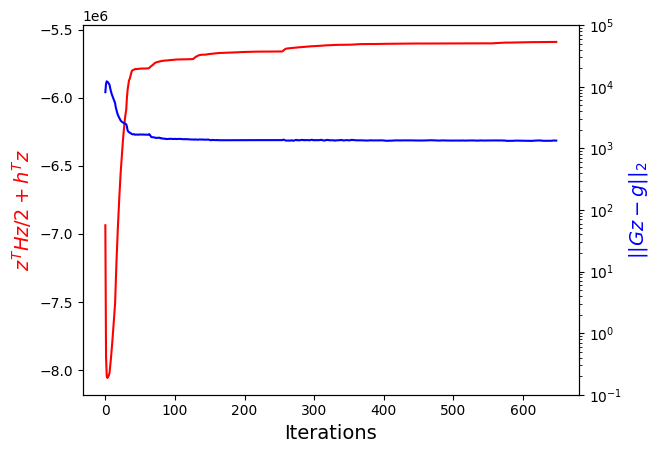

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27256
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.6181e+06   1.27e-01   8.12e+00   1.00e-01   4.11e-03s
  25  -5.6428e+06   1.45e-05   4.39e-05   1.00e-01   6.54e-03s

status:               solved
number of i

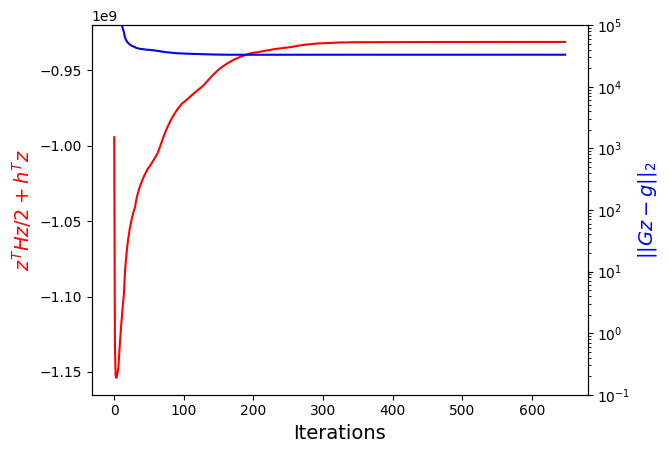

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27823
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.5100e+08   1.09e-02   3.48e+02   1.00e-01   4.39e-03s
  25  -9.1390e+08   1.12e-06   2.02e-02   1.00e-01   6.79e-03s

status:               solved
number of i

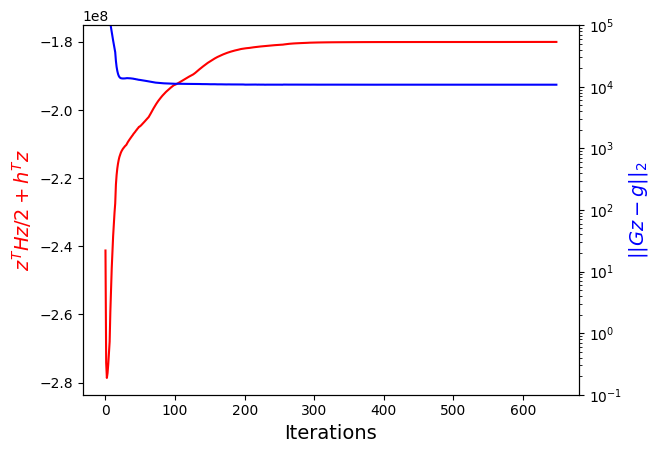

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27002
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2357e+08   2.30e-02   2.44e+02   1.00e-01   4.52e-03s
  25  -1.7027e+08   2.03e-06   1.11e-02   1.00e-01   7.02e-03s

status:               solved
number of i

In [66]:
ser_no = "04"
path = "NeuRIPS_data/anymal_quadruped/"+ser_no+"_anymal_"+scale_dict[ser_no]+"_scale/"
file_list=os.listdir(path)
print("---------------ANYMAL-----------------")
# solve_qp(path=path,file_list=[sorted(file_list)[3]], iter=650, type="anymal")
solve_qp(path=path,file_list=file_list, iter=650, type="anymal")

---------------ANYMAL-----------------
mpc_7200_0150.npz
(7224, 7224) (3624, 7224) (7224,) (3624,)
Correction_exp is 6 A_pre_fp_exp is -6 and Q_pre_fp_exp is -6


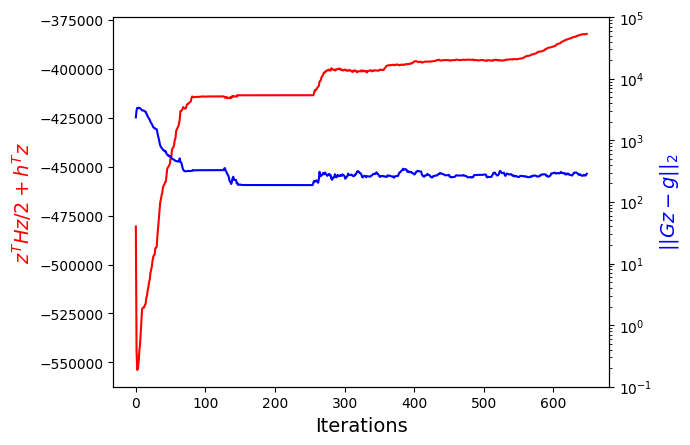

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 30954
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.7037e+05   3.33e-02   1.81e+00   1.00e-01   4.64e-03s
  25  -4.2206e+05   2.90e-06   8.55e-06   1.00e-01   7.23e-03s

status:               solved
number of i

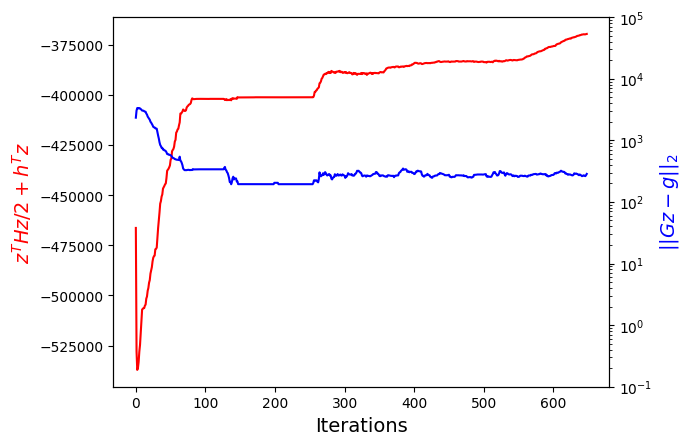

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 31099
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.6246e+05   3.55e-02   1.81e+00   1.00e-01   4.55e-03s
  25  -4.0973e+05   2.32e-06   8.55e-06   1.00e-01   7.07e-03s

status:               solved
number of i

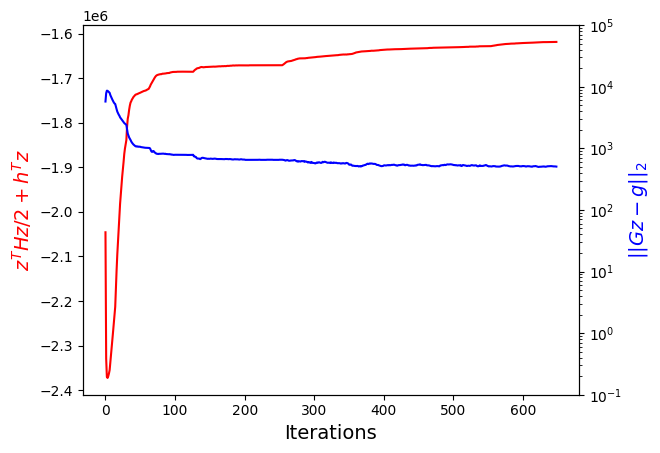

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 32634
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0687e+06   1.37e-02   5.43e+00   1.00e-01   6.18e-03s
  25  -1.6674e+06   1.62e-06   2.53e-05   1.00e-01   9.73e-03s

status:               solved
number of i

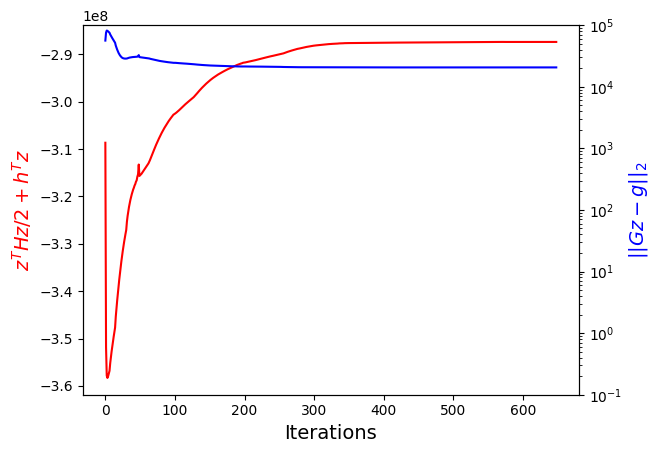

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 37506
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.0614e+08   5.23e-03   3.86e+02   1.00e-01   7.28e-03s
  25  -2.8338e+08   5.86e-07   3.56e-02   1.00e-01   1.11e-02s

status:               solved
number of i

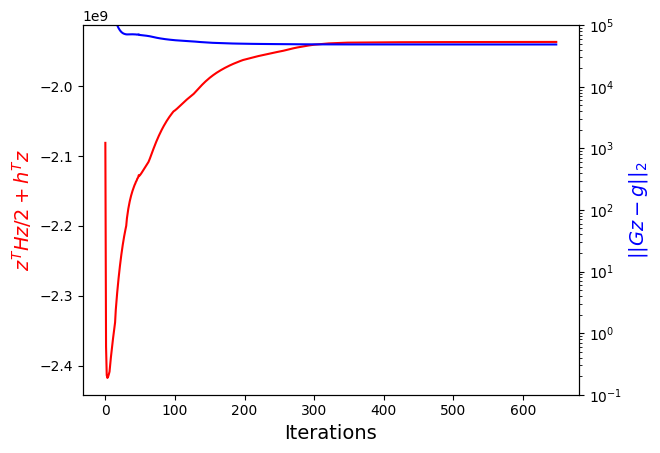

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 38836
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.4278e+09   7.06e-03   8.54e+02   1.00e-01   7.72e-03s
  25  -1.9055e+09   7.62e-07   7.10e-02   1.00e-01   1.16e-02s

status:               solved
number of i

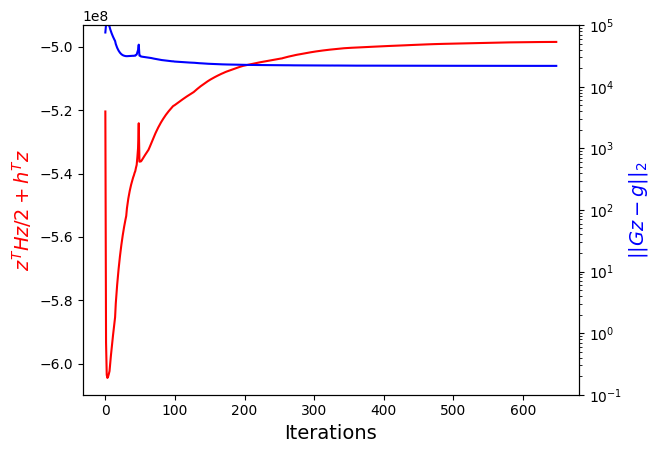

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 39041
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.3793e+08   2.00e-02   1.90e+02   1.00e-01   7.64e-03s
  25  -4.8963e+08   1.94e-06   8.67e-03   1.00e-01   1.16e-02s

status:               solved
number of i

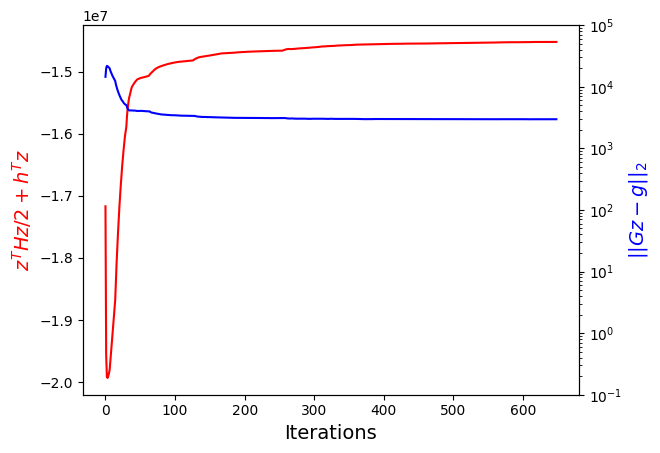

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 34714
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -9.3447e+06   4.25e-02   3.06e+01   1.00e-01   7.02e-03s
  25  -1.4493e+07   4.99e-06   1.75e-04   1.00e-01   1.09e-02s

status:               solved
number of i

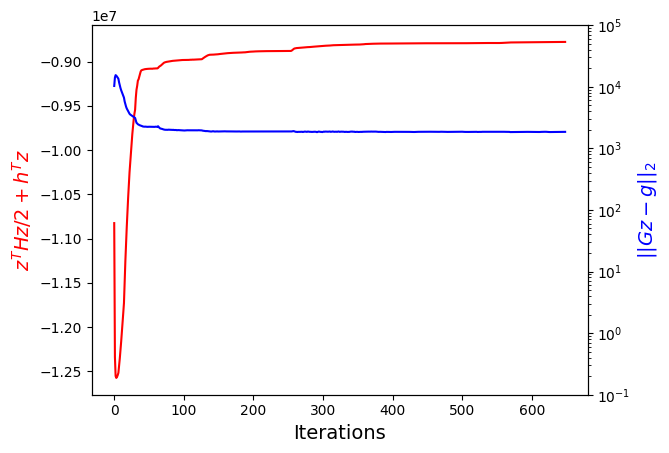

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 37714
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -5.6730e+06   1.20e-01   8.60e+00   1.00e-01   6.68e-03s
  25  -8.8468e+06   1.37e-05   4.66e-05   1.00e-01   1.06e-02s

status:               solved
number of i

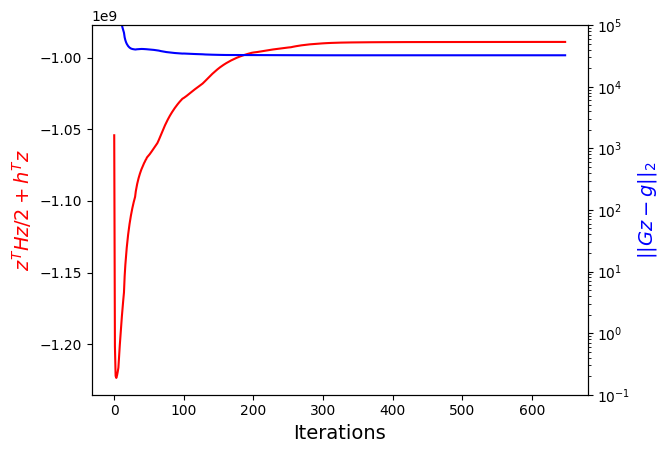

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 40051
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.9295e+08   1.09e-02   3.47e+02   1.00e-01   7.38e-03s
  25  -9.7176e+08   1.12e-06   2.02e-02   1.00e-01   1.14e-02s

status:               solved
number of i

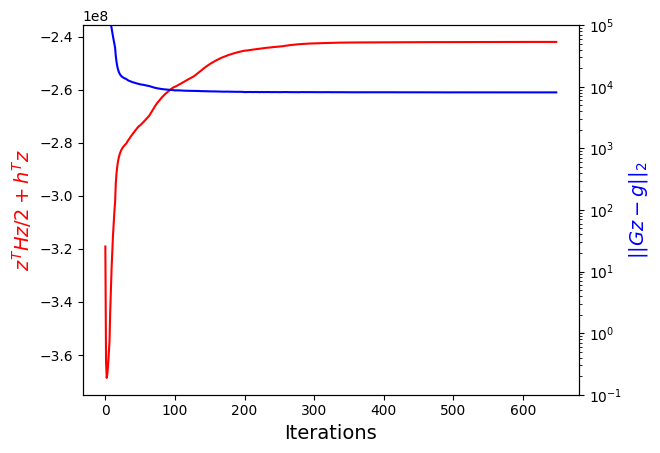

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 7224, constraints m = 3624
          nnz(P) + nnz(A) = 36993
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.6519e+08   2.30e-02   2.44e+02   1.00e-01   7.45e-03s
  25  -2.2854e+08   2.03e-06   1.11e-02   1.00e-01   1.21e-02s

status:               solved
number of i

In [67]:
ser_no = "05"
path = "NeuRIPS_data/anymal_quadruped/"+ser_no+"_anymal_"+scale_dict[ser_no]+"_scale/"
file_list=os.listdir(path)
print("---------------ANYMAL-----------------")
# solve_qp(path=path,file_list=[sorted(file_list)[3]], iter=650, type="anymal")
solve_qp(path=path,file_list=file_list, iter=650, type="anymal")

In [ ]:
convergence_z = [np.linalg.norm(t - s) for s, t in zip(sol, sol[1:])]
convergence_w = [np.linalg.norm(t - s) for s, t in zip(w_it, w_it[1:])]
# err_sol = [np.linalg.norm(res.x.reshape((res.x.shape[0], 1)) - s) for s in sol]
fig,ax = plt.subplots()
# ax.plot(err_sol, color="red")
# ax.set_ylabel("$||z-z^*||_2$",color="red",fontsize=14)

ax.plot(np.array(cost)[:,0,0], color="red")
ax.set_ylabel("$z^T H z/2 + h^T z $",color="red",fontsize=14)

ax.set_xlabel("Iterations",fontsize=14)

ax2=ax.twinx()
ax2.plot(constraint_sat,color="blue")
ax2.set_ylabel("$||Gz-g||_2$",color="blue",fontsize=14)
plt.show()